**Viscek Model**


> Viscek Model is a collective motion model which works based on the following assumptions:
1.  Individuals have constant absolute velocity
2.  At each time step, individuals assume the average velocity of the neighbors + random perturbation (noise)


> So, if:
*   N is the number of individuals
*   xᵢ(t) is the position vector of the individual i
*   𝛳 is the angle of the individuals
*   Δt is one time step
*   v0  is the speed of every individual
*   D is the length/width of the boundary
*   r is the interaction radius
*   Δ𝛳 is the random uniform noise, the Viscek model is as follows:
*   vₐ is the average normalized velocity 



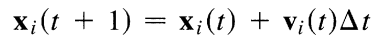

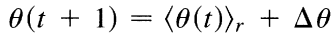

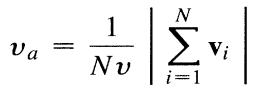

Based on these equations, let us construct the Viscek model!

Firstly, let us install and import all the packages we shall be necessarily using for this code.



















In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%pip install git+https://github.com/tee-lab/PyDaddy.git
#import pydaddy
import numpy; #package for numerical (matrix) calculations
import random
import matplotlib.pyplot as plt; #this gives us access to plotting functions
from matplotlib.animation import FuncAnimation # Used to animate the movement of the boids
from matplotlib import rc
import pandas as pd
from IPython.display import HTML, Image # For GIF
rc('animation', html='html5')

Each individual is associated with two continuosly changing (with time) variables: position and angle. Therefore, to store these values we need vectors. To do so, we write a function to initialize the vectors to store these values and assign them a random initial state. The function below creates the vectors and assigns them random initial values and returns these initial state vectors.

In [3]:
def initializeBoids(N, D):                                   # Function to give initial random positional values to the N number of boids
    boid_angle_state0 = numpy.zeros( shape=(N))                # We created an angle array of size N and assigned all angles to 0 initially
    boid_pos_state0 = numpy.zeros( shape=(2,N))                
    boid_angle_state0 = numpy.random.uniform(-numpy.pi,numpy.pi,N)    # Here we assign a random angle from 0 to 2pi to all the boids
    boid_pos_state0[0,:] = numpy.random.rand(N) * D           # Assigning random positional values to the boids
    boid_pos_state0[1,:] = numpy.random.rand(N) * D
    return  boid_angle_state0, boid_pos_state0;

To visualize how the individuals would look like in an enclosement, we plot them (their positions and angles within the boundary). 

In [4]:
def plotBoids(angle, pos, D):                          # Function to plot the boids on a 2D plane (its enclosure)
    fig = plt.axes()
    fig.set_xlim(0,D)                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
    fig.set_ylim(0,D)
    Scale = D/250
    N = numpy.size(angle)                                        # determine the number of boids from the size of vector/array
    for n in range(N):
        xpos, ypos = pos[0,n], pos[1,n]
        fig.arrow( xpos, ypos, 5*Scale*numpy.cos(angle[n]), 5*Scale*numpy.sin(angle[n]), head_width=2*Scale, head_length=Scale, fc='green', ec='green') # plotting an arrow to depict the boids, alternative: Use a quiver plot

    plt.show()                                                   # This plots the boids on said enclosure
    return fig

Another variable in this system would be the velocity of the individuals which constantly varies in directly but remains constant in magnitude. Therefore, to keep track of velocity of inidividuals, we initialize a vector and store the x and y components of the velocity of all individuals:

In [5]:
def calcVel(N,v0, angle):
  v_vec = numpy.zeros(shape=(2,N))
  for n in range(N):
    theta= angle[n]
    v_vec[0,n]= v0*numpy.cos(theta)
    v_vec[1,n]= v0*numpy.sin(theta)
  return(v_vec)

Since each individuals velocity is influenced by its neighbors, we must determine these neighbors for every individuals. To do so, we use the following function, which determines the individuals within a certain radius of an individual by examining the distance between individuals.

In [ ]:
x = numpy.zeros( shape=(2,10))  
x

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
def neighborCal(current_angle, current_pos, neighborMeanAngles, N, R, r_r, D, boundary):
    for i in range (N):
        neighborAngle=[]
        i_pos = current_pos[:,i].copy()
        n_r = 0
        dir_r_x_list = []     # It is a list containing the x component of the unit vectors of the boids in the zone of repulsion of i
        dir_r_y_list = []     # It is a list containing the y component of the unit vectors of the boids in the zone of repulsion of i
        for j in range (N):
            j_pos = current_pos[:,j].copy()
            dir_ij = [0,0]
            dist_x = i_pos[0] - j_pos[0]
            dist_y = i_pos[1] - j_pos[1]
            if(boundary == 1):
              if (dist_x > D/2 ):
                dist_x = dist_x - D
                j_pos[0] = j_pos[0] + D
              if (dist_x < -D/2 ):
                dist_x = dist_x + D
                j_pos[0] = j_pos[0] - D
              if (dist_y > D/2 ):
                dist_y = dist_y - D
                j_pos[1] = j_pos[1] + D
              if (dist_y < -D/2 ):
                dist_y = dist_y + D
                j_pos[1] = j_pos[1] - D
            dist_ij = numpy.sqrt(numpy.square(dist_x)+numpy.square(dist_y))
            dir_ij[0] = j_pos[0] - i_pos[0]    # This is the x component of the unit vector of the direction vector of i to j
            dir_ij[1] = j_pos[1] - i_pos[1]    # This is the y component of the unit vector of the direction vector of i to j
            if (dist_ij < r_r and i != j):
              n_r = n_r + 1
              dir_r_x_list.append(dir_ij[0])  
              dir_r_y_list.append(dir_ij[1])
            if (n_r == 0):
               if ((r_r <= dist_ij < R) or i==j):
                   neighborAngle.append(current_angle[j]) 
        if (n_r > 0):
          denom_r = 0
          index = 0
          dir_x = 0
          dir_y = 0
          for index in range(len(dir_r_x_list)):
              denom_r = numpy.sqrt(numpy.square(dir_r_x_list[index])+numpy.square(dir_r_y_list[index]))
              dir_x = dir_x + (dir_r_x_list[index]/denom_r)
              dir_y = dir_y + (dir_r_y_list[index]/denom_r)
          neighborMeanAngles[i] =  numpy.arctan2(-dir_y, -dir_x)
        else:
            if (len(neighborAngle) >= 4):
              chosen_angles = random.sample(neighborAngle, 4)
              neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(chosen_angles)), numpy.mean(numpy.cos(chosen_angles)))
            elif (len(neighborAngle) == 3):
              chosen_angles = random.sample(neighborAngle,3)
              neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(chosen_angles)), numpy.mean(numpy.cos(chosen_angles)))
            elif (len(neighborAngle) == 2):
              chosen_angles = random.sample(neighborAngle,2)
              neighborMeanAngles[i] =  numpy.arctan2(numpy.mean(numpy.sin(chosen_angles)), numpy.mean(numpy.cos(chosen_angles)))
            else:
              neighborMeanAngles[i] = random.choice(neighborAngle)
    
    return (neighborMeanAngles)

This model is of the form:
future (state) = f (current (state)). Threfore, the determine the next state of each individual we neet to input their current states. The calculations to get the next state, in tune with the model equations are done below:

In [7]:
def state_update(present_angle, present_pos, time_step, eta, R, r_r, D, v0, N, boundary):      # Function to update the state of boids according to the Viscek model
    current_angle = present_angle.copy()
    current_pos  = present_pos.copy()
    next_angle = numpy.zeros(N)                                   # first set the next state to the current state of the boids
    next_pos = numpy.zeros(shape=(2,N)) 
    neighborMeanAngles = numpy.zeros(N)
    next_v = numpy.zeros(shape=(2,N))
    neighborMeanAngles = neighborCal(current_angle, current_pos, neighborMeanAngles, N, R, r_r, D, boundary)
    #noise = (numpy.random.rand(N) - 0.5) * eta
    noise = numpy.zeros(shape=(N))
    for n in range(N):
      noise[n]=numpy.random.uniform(-eta/2,eta/2)

    next_angle = numpy.add(neighborMeanAngles, noise) # Updating the angular data of the boid by assigning neighbor average angle and adding noise
    
    for n in range(N):      # Here, we update the boid positions one by one
        v_x = v0*numpy.cos(next_angle[n])
        v_y = v0*numpy.sin(next_angle[n])                               # Current velocity values
        next_pos[ 0,n ] = current_pos[ 0,n ] + time_step*v_x       # x1 = x0 + delta_t * v (updating the position)
        next_pos[ 1,n ] = current_pos[ 1,n ] + time_step*v_y
        if (boundary == 1):  
          next_pos[ 0,n ] = numpy.mod( next_pos[ 0,n ], D)           # Introducing periodic boundary by using mod
          next_pos[ 1,n ] = numpy.mod( next_pos[ 1,n ], D) 
        else:
          if (next_pos[0,n]<0):
            next_pos[0,n] = - next_pos[0,n]
            next_angle[n] = numpy.arctan2(numpy.sin(next_angle[n]), -numpy.cos(next_angle[n]))       # Introducing reflective boundary
          elif (next_pos[0,n]>D):
            next_pos[0,n] = (2*D) - next_pos[0,n] 
            next_angle[n] = numpy.arctan2(numpy.sin(next_angle[n]), -numpy.cos(next_angle[n]))
          if (next_pos[1,n]<0):
            next_pos[1,n] = - next_pos[1,n]
            next_angle[n] = numpy.arctan2(-numpy.sin(next_angle[n]), numpy.cos(next_angle[n]))
          elif (next_pos[1,n]>D):
            next_pos[1,n] = (2*D) - next_pos[1,n] 
            next_angle[n] = numpy.arctan2(-numpy.sin(next_angle[n]), numpy.cos(next_angle[n]))
    
    next_v[:,:]= calcVel(N,v0, next_angle)
   # for n in range(N):
    #  theta = next_angle[n]
     # v_vector[numpy.array([0,1]) + 2*n] = v0*numpy.array([numpy.cos(theta),numpy.sin(theta)])                                                           # Calculating the next velocity vector of individual n and storing it
    return(next_angle, next_pos, next_v)

The following function plots the trajectory of all individuals during the time period:

In [8]:
def plottrajectories(trajectory_angles, trajectory_pos, D):        # This plots the trajectory of the boids (i.e., the path followed by each boids during the duration of the simulation)
    ax = plt.axes()
    ax.set_xlim(0,D)                                                  # Setting axes of the plot
    ax.set_ylim(0,D)
    plt.plot( trajectory_pos[0,:,:].T, trajectory_pos[1,:,:].T ,'.')  # Plottng the trajectories {Plotting the co-ordinates of each boid over time by transposing the matrix to acess the coordinates of each boid over time (without transposing, you would get the coordinates of all boids in one time frame instead)}

The following function is responsible for plotting various plots to show the boid movement information according to the viscek model. Initial and final state of boids, trajectory of boids, change in average velocity over time and change in order parameter over time are displayed:

In [ ]:
def plotCall(trajectory_angles, trajectory_pos, Order_param, avg_vel, time, D):
  #Plotting data
    plt.figure(0)
    plottrajectories(trajectory_angles, trajectory_pos,D) # trajectory plot
    plt.figure(1)
    plotBoids(trajectory_angles[:,0], trajectory_pos[:,:,0], D) # initial state of boids
    plt.figure(2)
    plotBoids(trajectory_angles[:,-1], trajectory_pos[:,:,-1], D) #final state of boids 
    print(avg_vel)                                                # Displaying the order parameter over time
    plt.figure(3)
    plt.ylim(0,1)
    plt.scatter(time,avg_vel)                                     # Average velocity plot
    plt.plot(time,avg_vel)
    plt.xlabel("T")
    plt.ylabel("Order parameter (Avg vel)")
    plt.show
    plt.figure(4)                                                   
    plt.ylim(-1,1)
    plt.scatter(time,Order_param[0,:], c = 'red')                # Order parameter (along x and y) plot
    plt.scatter(time,Order_param[1,:], c = 'green')
    plt.plot(time,Order_param[0,:], c = 'red', label = 'M_x')
    plt.plot(time,Order_param[1,:], c = 'green', label = 'M_y')
    plt.legend(['M_x', 'M_y'])
    plt.xlabel("T")
    plt.ylabel("Order parameter (Avg vel)")
    plt.show

The following function is used to do data-driven analysis using pyDaddy:

In [ ]:
def pyDaddyCall (Order_param,time_step):

    ddsde = pydaddy.Characterize(Order_param, time_step)
    F1 = ddsde.fit('F1', order=3, threshold=0.01)
    print("F1 =",F1)
    F2 = ddsde.fit('F2', order=3, threshold=0.01)
    print("F2 =",F2)
    G11 = ddsde.fit('G11', order=3, threshold=0.01)
    print("G11 =",G11)
    G22 = ddsde.fit('G22', order=3, threshold=0.01)
    print("G22 =",G22)
    G12 = ddsde.fit('G12', order=3, threshold=0.01)
    print("G12 =",G12)
    G21 = ddsde.fit('G21', order=3, threshold=0.01)
    print("G21 =",G21)
    print("When tune = true i.e., when the program sets the treshold:")
    F1 = ddsde.fit('F1', order=3, tune=True)
    print("F1 =",F1)
    F2 = ddsde.fit('F2', order=3, tune=True)
    print("F2 =",F2)
    G11 = ddsde.fit('G11', order=3, tune=True)
    print("G11 =",G11)
    G22 = ddsde.fit('G22', order=3, tune=True)
    print("G22 =",G22)
    G12 = ddsde.fit('G12', order=3, tune=True)
    print("G12 =",G12)
    G21 = ddsde.fit('G21', order=3, tune=True)
    print("G21 =",G21)
    ddsde.drift()
    ddsde.diffusion()
    ddsde.cross_diffusion()
    ddsde.summary()
    ddsde.noise_diagnostics()

Now that we have all the major functions to make the viscek model, we need to conduct a trial with all the initial state values. To do so, we use the following function which takes in the initial values as an input to give us the output (plots, pyDaddy analysis, and position and angles of the boids during the duration of the trial):

In [9]:
def trial(N, eta, T, R, r_r, D, time_step, v0, boundary, var): # values listed here are 'defaults': they are used if we don't specify the appropriate constant

    angle_state0, pos_state0 = initializeBoids(N, D)          # We create and initialize state 0 (t=0) positional and angular values of the boids
    trajectory_angles = numpy.zeros(shape=(N,T))                # Creating matrices to store positional and angular data of boids over time
    trajectory_pos = numpy.zeros( shape=(2,N, T));
    trajectory_angles[:,0] = angle_state0
    trajectory_pos[:,:,0] = pos_state0
    v_vector = numpy.zeros(shape=(2,N,T))                       # Matrix to store velocity data of boids over time
    v_vector[:,:,0]= calcVel(N,v0, angle_state0)
    time = numpy.arange(0,T,1) 
    for t in range(T-1):                                        # Looping to update matrices with position, angles and velocity data
        trajectory_angles[:,t+1], trajectory_pos[:,:,t+1], v_vector[:,:,t+1] = state_update( trajectory_angles[:,t], trajectory_pos[:,:,t], time_step, eta, R, r_r, D, v0, N, boundary) # repeatedly calling state update to get data
    #Order parameter calculation below:
    avg_vel = numpy.zeros(T)    #Initialize an average velocity vector of size T that serves as a order parameter
    M_x = numpy.zeros(T)
    M_y = numpy.zeros(T)
    Order_param = numpy.zeros(shape=(2,T))
    for t in range(T):        # Looping T times to get average velocity for every time step
      avg_vel[t]= numpy.sqrt((numpy.square(numpy.sum(v_vector[0,:,t]))+numpy.square(numpy.sum(v_vector[1,:,t]))))/(N*v0)  # Avg vel = magnitude of (sum of velocity vectors)/ (Number of boids * magnitude of velocity)
      M_x[t] = numpy.sum(v_vector[0,:,t])/(N*v0)
      M_y[t] = numpy.sum(v_vector[1,:,t])/(N*v0)
      Order_param[0,t]=M_x[t]
      Order_param[1,t]=M_y[t]
      
    #print(Order_param)
    #plotCall(trajectory_angles, trajectory_pos, Order_param, avg_vel, time, D)    # Calling function to make the plots
    #numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Viscek_Reflective_Square_Next_Direction/D_4/Trajectory_angles_Simulation_'+str(var)+'.csv', trajectory_angles, delimiter=",")
    #traj_pos_reshaped =trajectory_pos.reshape(trajectory_pos.shape[0], -1)
    #numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Viscek_Reflective_Square_Next_Direction/D_4/Trajectory_positions_Simulation_'+str(var)+'.csv', traj_pos_reshaped, delimiter=",")
    numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Limited_Neighbor_Models/Four_Neighbors_Only_Self_Included/Reflective Square/N_10/Eta_'+str(eta)+'_R_'+str(R)+'Order_parameter_Simulation_'+str(var)+'.csv', Order_param, delimiter=",")
    numpy.savetxt('/content/drive/MyDrive/Colab_Notebooks_New/Limited_Neighbor_Models/Four_Neighbors_Only_Self_Included/Reflective Square/N_10/Eta_'+str(eta)+'_R_'+str(R)+'Average_velocity_direction_Simulation_'+str(var)+'.csv', avg_vel, delimiter=",")
    #pyDaddyCall (Order_param,time_step)                                                  # Calling funtion to do the data-drive SDE analysis using pyDaddy

    return(trajectory_pos,trajectory_angles)

In [10]:
#Note: The animation doesn't work on colab and has to be executed on spyder or other platforms

def Animate(t):               # Function to get the animation of boids moving over time
      if (t<anim_time ):              # Function will run till we reach timestep T
        plt.cla()             # Clears the plot before displaying new positions of the boids
        plt.xlim(0,D)                                            # Setting the limit of x and y axes therefore assigning a size to the enclosure
        plt.ylim(0,D)
        plt.title("T = %i" % t)
        plt.suptitle("N=%i  " %N + "eta=%s  " %eta +  "D=%s  " %D +  "r=%s  " %R + "r_r=%s " %r_r + "v=%s" %v)
        Scale = D/250
        plt.quiver(traj_pos[0,:,t],traj_pos[1,:,t],numpy.cos(traj_angles[:, t]), numpy.sin(traj_angles[:, t]),  pivot='tip', scale = 30, color = "red") # Displaying the boids positions at time t

Now that everything is ready, we just need to call the trial function with input values. For that, we take input values from the user and call trial.

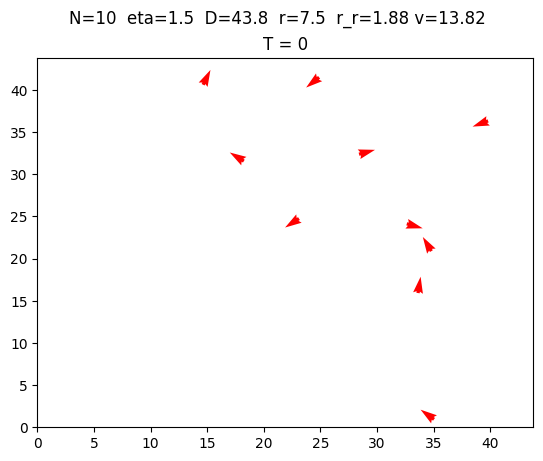

In [11]:

# The next few lines of code is to collect parameter values (input) from the user
#Note: The spyder platform I use doesn't support collecting imput from users so if you face the same problem, just directly assign values to N and eta in the code.
#N =int(input("Enter the number of boids you want in the enclosure: "))
#eta = float(input("Enter the maximum noise in the system: "))
#D = float(input("Enter the size of the enclosure D (one side in units):")) 
#R = float(input("Enter the radius of interaction (in units):"))
#v = float(input("Enter the speed of the boids (in units/sec):"))
#boundary = int(input("The type of boundary (0 for reflective and 1 for periodic): "))
N = 10
eta = 1.5
D = 43.8
R = 7.5 
r_r = 1.88
v = 13.82
T = 1000000   # This is the number of timesteps in the simulation
time_step = 0.1
anim_time = 1000
set_of_R = [7.5]
eta_values = [1.5]
boundary = 0
var = 0
for eta in eta_values:
  for R in set_of_R:
      for var in range(1):
        traj_pos, traj_angles = trial(N, eta, T, R, r_r, D, time_step, v, boundary, var)# Calling the trial function
        t=0 
        plt.figure(5)
        ani = FuncAnimation(plt.gcf(),Animate,interval=1, frames=anim_time, repeat_delay=1000)    # Animation
        ani.save('/content/drive/MyDrive/Colab_Notebooks_New/Limited_Neighbor_Models/Four_Neighbors_Only_Self_Included/Reflective Square/N_10/Eta_'+str(eta)+'_R_'+str(R)+'Simulation_'+str(var)+'.gif',writer = "pillow", fps=40)


To observe the simulation of the boids moving in accordance to the Viscek model, we use the following function:

The following snippet of code is to call the animation function! This should result in a animation of boids moving.